In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch_sparse import SparseTensor
from scipy.stats import special_ortho_group
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from l2gx.align.utils import to_device
from l2gx.graphs import TGraph
from l2gx.datasets import get_dataset
from l2gx.patch.patches import create_patch_data
from l2gx.graphs import induced_subgraph
from l2gx.patch.clustering import fennel_clustering

# <font color="grey"> Experiments with DGraph</font>

In [5]:
# The Dgraph dataset requires registration. It needs to be downloaded from the website and placed in the data folder.
dgraph = get_dataset("DGraph", root="../data/dgraph", source_file="../data/DGraphFin.zip")
print(dgraph[0])
data = dgraph[0]

2025-03-26 13:03:40,277 - INFO - File ../data/dgraph/raw/DGraphFin.zip already exists in raw directory, skipping download
2025-03-26 13:03:41,013 - INFO - NumExpr defaulting to 8 threads.


Loading edge and node data from memory


Data(x=[3700550, 17], edge_index=[2, 4300999], y=[3700550], edge_type=[4300999], edge_time=[4300999], train_mask=[3700550], val_mask=[3700550], test_mask=[3700550])


In [6]:
# Do some preprocessing
nodes = torch.concat((data.edge_index[0,:],data.edge_index[1,:])).unique()
data.nodes = nodes
data.adj_t = SparseTensor(row=data.edge_index[0], col=data.edge_index[1], sparse_sizes=(data.num_nodes, data.num_nodes))
data.adj_t = data.adj_t.to_symmetric()  
tgdata = TGraph(edge_index=data.edge_index,  num_nodes=data.num_nodes, x=data.x, ensure_sorted=True, undir=False)


In [8]:
partition_tensor = fennel_clustering(tgdata, 400)
pt, pgraph = create_patch_data(
    tgdata, 
    partition_tensor= partition_tensor,
    min_overlap=200_000, 
    target_overlap=500_000, 
    verbose=True)
patch_data = [induced_subgraph(data, p) for p in pt]

TypingError: Failed in nopython mode pipeline (step: Handle with contexts)
[1mMissing type annotation on outgoing variable(s): ['progress']

Example code: with objmode(progress='<add_type_as_string_here>')
[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'torch.Tensor'>[0m
- argument 1: [1mCannot determine Numba type of <class 'torch.Tensor'>[0m


Compute mean embedding:   0%|          | 0/10 [00:00<?, ?it/s]

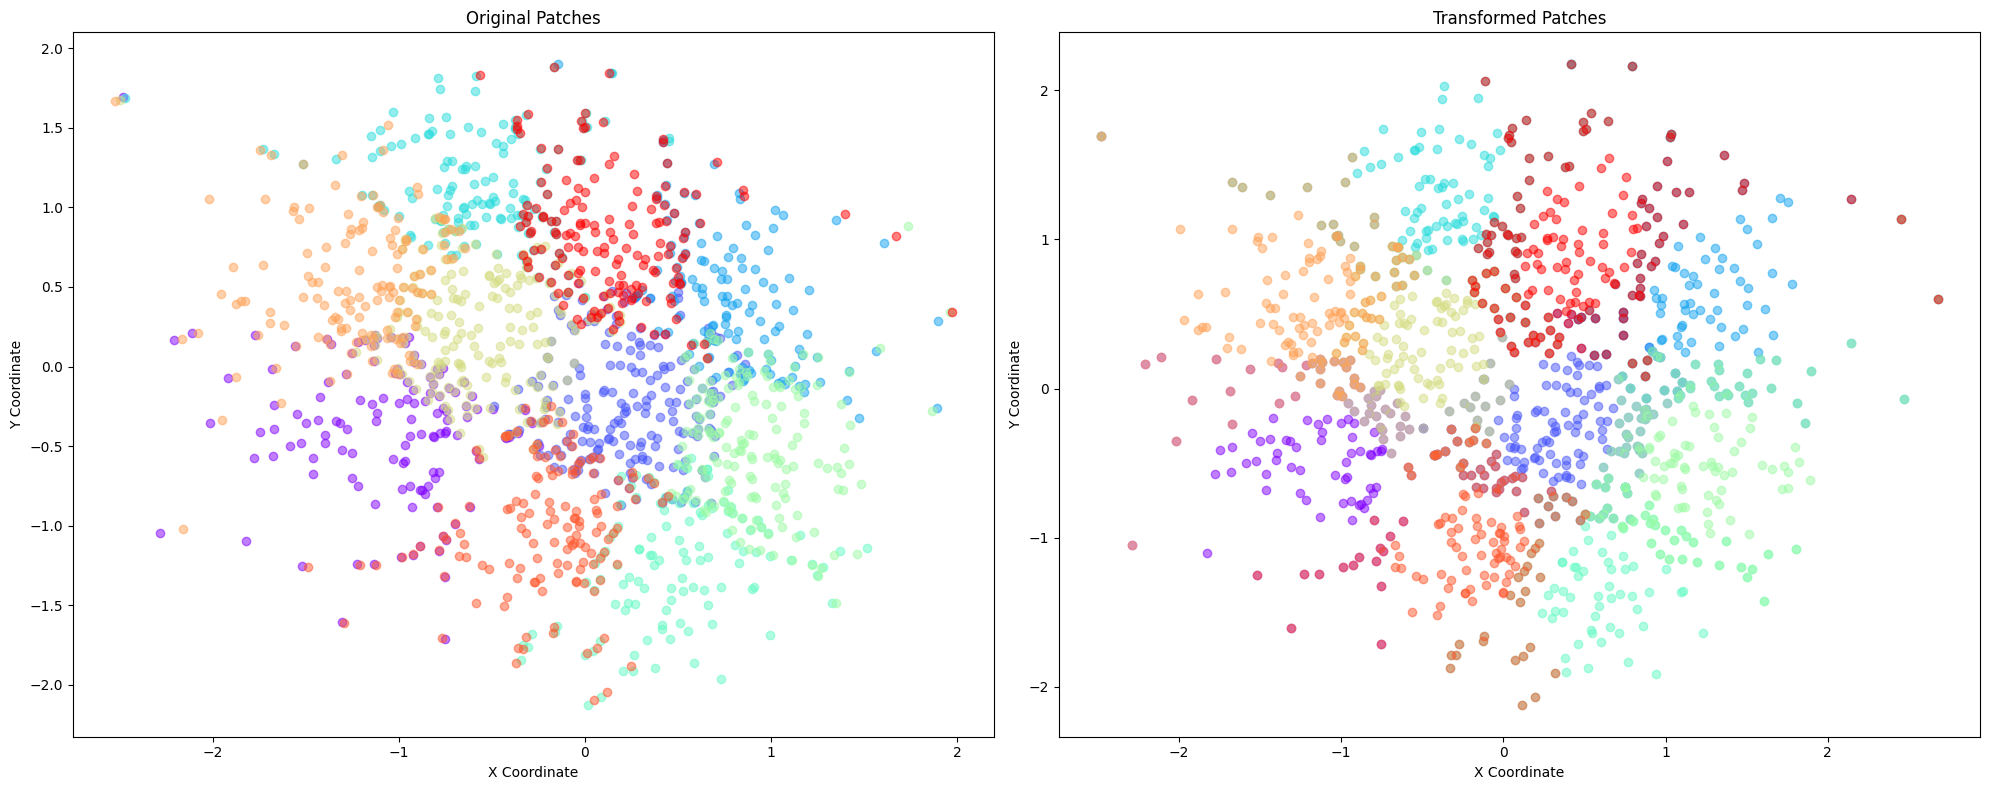

In [140]:
geo_aligner = get_aligner(
    "geo", 
    patches=transformed_patches,
    num_epochs=500,
    learning_rate=0.1,
    model_type="affine")
embedding = geo_aligner.get_aligned_embedding()
plot_patches(geo_aligner.patches, patches)

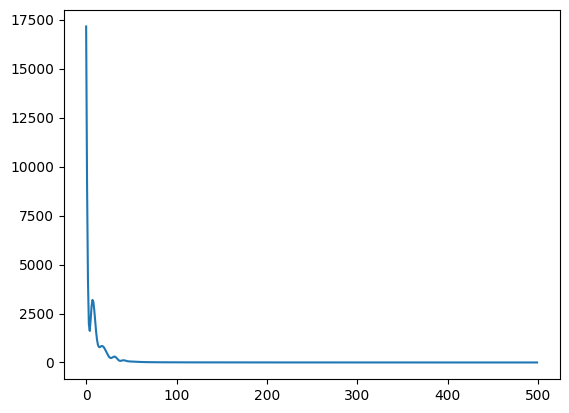

In [141]:
plt.plot(geo_aligner.loss_hist)
plt.show()

###  <a id='chapter6'> <font color="grey">6. Embedding </font></a>

The coordinates of a patch come from an embedding of a graph into Euclidean space. 
For the embedding, we use the architecture of a Variational Graph Autoencoder. Given a graph $G=(V,E)$ with $|V|=n$ nodes and node features ${x}_i\in \mathbb{R}^d$, $i\in [n]$, denote by ${X}=[{x}_1,\dots,{x}_n]^T\in \mathbb{R}^{n\times d}$ the features matrix and by $A=(a_{ij})\in \{0,1\}^{n\times n}$ the adjacency matrix of the graph. The **encoder** produces latent representations ${z}_i\in \mathbb{R}^k$ for $i\in [n]$, which are sampled from the inference model
\begin{equation*}
  q({z}_i \ | \ {X},{A}) = \mathcal{N}({z}_i \ | \ {\mu}_i,\mathrm{diag}({\sigma}_i)).
\end{equation*}
The means $\mu_i$ and variances $\mathrm{diag}({\sigma}_i)$ are parametrized using an encoder network, for example, a graph convolutional neural network (GCN). Denoting by ${Z}=[{z}_1,\dots,{z}_n]^T$ the matrix of latent represenations and by ${\mu}$ and ${\sigma}$ the matrices representing the means and variances, we have
\begin{equation*}
  {\mu} = \mathrm{GCN}_{\mu}({X},{A}), \quad \quad \log {\sigma} = \mathrm{GCN}_{\sigma}({X},{A}).
\end{equation*}
The **generative model** is a distribution on the adjacency matrix,
\begin{equation*}
  p({A}\ | \ {Z}) = \prod_{i,j} p(a_{ij} \ | \ {z}_i,{z}_j).
\end{equation*}
It is convenient to use
\begin{equation*}
  p(a_{ij}=1 \ | \ {z}_i,{z}_j) = \sigma({z}_i^T{z}_j),
\end{equation*}
where $\sigma$ is the logistic sigmoid. In order to train the model, we optimize the evidence lower bound
\begin{equation*}
  \mathcal{L} = \mathbb{E}_{q({Z}\ | \ {X},{A})}[\log p({A}\ | \ {Z})]-\mathrm{D}_{\mathrm{KL}}(q({Z}\ | \ {X},{A}) \ \| \ p({Z})).
\end{equation*}

In [ ]:
from l2gx.embedding.gae import VGAE
from l2gx.embedding.train import train
from l2gx.embedding.gae.utils.loss import VGAE_loss

In [143]:
model = VGAE(dim=64, hidden_dim=128, num_features=tg.x.shape[1]).to(device)
model = train(cora[0], model, loss_fun=VGAE_loss, num_epochs=200, verbose=False, lr=0.001)
with torch.no_grad():
    model.eval()
    coordinates = model.encode(cora[0]).to("cpu").numpy()

In [144]:
reducer = UMAP(n_components=2, random_state=42)
umap_data = reducer.fit_transform(coordinates)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


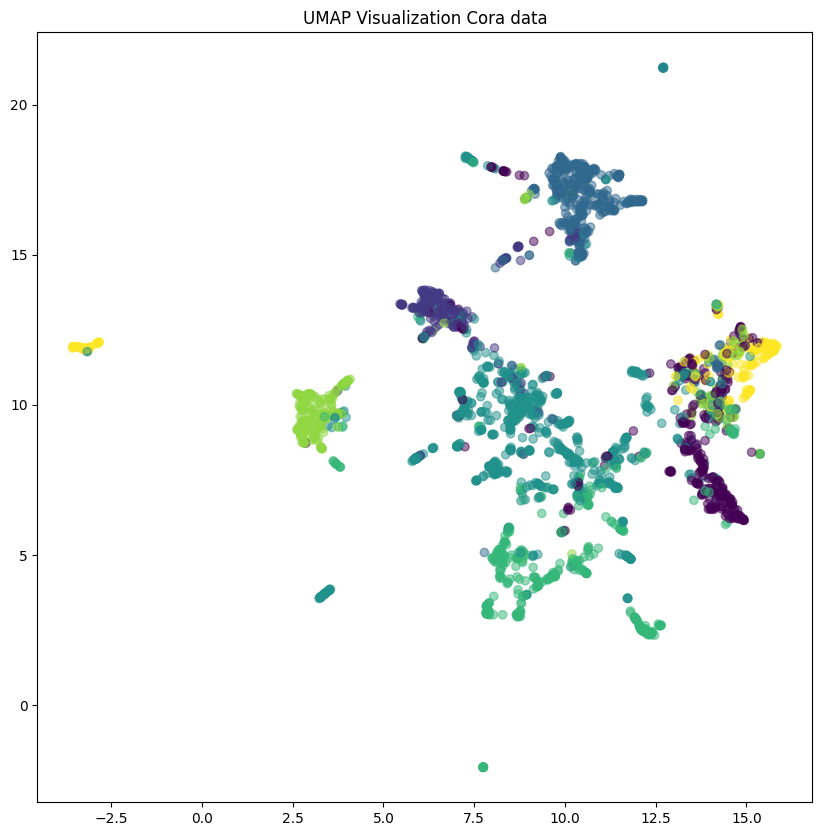

In [145]:
plt.figure(figsize=(10, 10))
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=cora[0].y, cmap='viridis', alpha=0.5)
plt.title('UMAP Visualization Cora data')
plt.show()

###  <a id='chapter7'> <font color="grey">7. Hierarchical alignment </font></a>

To be done.

###  <a id='chapter8'> <font color="grey">8. Visualisation </font></a>

For the visualisation, it is convenient to use external packages such as Heimdall.